In [26]:
#  ===== -- Step 1 -- =====

#  ===== -- Importing the required libraries -- =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# ===== -- Adding extra model comparisons -- =====
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense



In [ ]:
# ===== -- Step 2 -- =====
# ===== -- Load the dataset -- =====

# Load only the first 100,000 rows to avoid memory issues, the entire dataset consumes a lot of RAM, yikes
df = pd.read_csv('C:\Users\Administrator\Documents\data\ML-EdgeIIoT-dataset.csv', low_memory=False)

# Check shape and label distribution
print("Shape:", df.shape)
print("Attack_label value counts:")
print(df['Attack_label'].value_counts())





Shape: (157800, 63)
Attack_label value counts:
Attack_label
1    133499
0     24301
Name: count, dtype: int64


In [ ]:
# ===== -- Step 3 -- =====
# ===== -- Drop non-numeric and irrelevant columns -- =====

drop_cols = [
    'frame.time', 'ip.src_host', 'ip.dst_host',
    'arp.dst.proto_ipv4', 'arp.src.proto_ipv4', 'arp.opcode', 'arp.hw.size',
    'http.file_data', 'http.request.uri.query', 'http.request.method', 'http.referer', 
    'http.request.full_uri', 'http.request.version', 'tcp.options', 'tcp.payload',
    'dns.qry.name.len', 'mqtt.conack.flags', 'mqtt.msg', 'mqtt.protoname', 'mqtt.topic',
    'Attack_type'  # this one is the multiclass column we are not using for binary classification
]

# Drop any columns that exist in the dataset to avoid confusion with the training later, with XGBoost
df_clean = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Drop rows with NaN, inf, or -inf
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(inplace=True)

# Confirm new shape after cleaning
print("After cleaning, shape:", df_clean.shape)


After cleaning, shape: (157800, 42)


In [ ]:
# After long hustle we do an absolute cleaning to kill ALL string/label issues (this one must run BEFORE splitting X and y)

# Drop any object (string/categorical) columns if they exist
non_numeric_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

print("Non-numeric columns to drop:", non_numeric_cols)

# Drop them from df_clean
df_clean = df_clean.drop(columns=non_numeric_cols)

# Confirm it's all numeric now
print("\nRemaining types in df_clean:\n", df_clean.dtypes.value_counts())


Non-numeric columns to drop: ['tcp.srcport']

Remaining types in df_clean:
 float64    40
int64       1
Name: count, dtype: int64


In [47]:
# ===== -- Step 4: Split into Features and Labels -- =====

# Separate features (X) and label (y)
X = df_clean.drop(columns=['Attack_label'])
y = df_clean['Attack_label']

# Confirm shapes
print("Features shape:", X.shape)
print("Target shape:  ", y.shape)

# ===== -- Step 5: Split into Train, Validation, and Test sets -- =====

# First, split into 85% train+val and 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# Then split the temp set into 80% train and 20% val (which becomes 68% train, 17% val total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2,
    stratify=y_temp,
    random_state=42
)

# Confirm distributions
print("\nClass distribution (Train):\n", y_train.value_counts())
print("Class distribution (Val):\n", y_val.value_counts())
print("Class distribution (Test):\n", y_test.value_counts())

# Print shapes
print(f"\nTrain shape:     {X_train.shape}")
print(f"Validation shape:{X_val.shape}")
print(f"Test shape:      {X_test.shape}")


Features shape: (157800, 40)
Target shape:   (157800,)

Class distribution (Train):
 Attack_label
1    90779
0    16525
Name: count, dtype: int64
Class distribution (Val):
 Attack_label
1    22695
0     4131
Name: count, dtype: int64
Class distribution (Test):
 Attack_label
1    20025
0     3645
Name: count, dtype: int64

Train shape:     (107304, 40)
Validation shape:(26826, 40)
Test shape:      (23670, 40)


In [30]:
# Split into Train (70%), Validation (15%), and Test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (140080, 40)
Val shape: (29920, 40)
Test shape: (30000, 40)


In [49]:
# ===== -- Step 6: Standardize the features -- =====

scaler = StandardScaler()

# Fit on training set and transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Confirm the transformation
print("Scaling complete. Shapes:")
print("Train:", X_train_scaled.shape)
print("Val:  ", X_val_scaled.shape)
print("Test: ", X_test_scaled.shape)
print("✅ Scaling done.")


Scaling complete. Shapes:
Train: (107304, 40)
Val:   (26826, 40)
Test:  (23670, 40)
✅ Scaling done.


In [41]:
print(X.dtypes.value_counts())


float64    40
object      1
Name: count, dtype: int64


In [42]:
print("\nNon-numeric columns in X:")
print(X.select_dtypes(exclude=['number']).columns.tolist())




Non-numeric columns in X:
['tcp.srcport']


In [43]:
# Extra cleaning — drop any text-based columns we missed
more_non_numeric = X.select_dtypes(exclude=['number']).columns.tolist()
print("Dropping extra columns:", more_non_numeric)
X = X.drop(columns=more_non_numeric)


Dropping extra columns: ['tcp.srcport']


🔍 Random Forest Validation Accuracy: 0.9944084097517334

📊 Classification Report (Random Forest):
              precision    recall  f1-score   support

           0     0.9835    0.9802    0.9818      4131
           1     0.9964    0.9970    0.9967     22695

    accuracy                         0.9944     26826
   macro avg     0.9899    0.9886    0.9893     26826
weighted avg     0.9944    0.9944    0.9944     26826



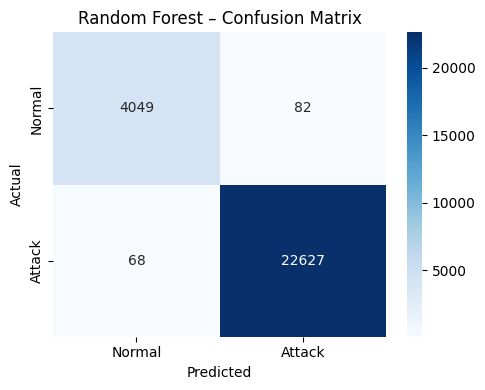

In [ ]:
# ===== -- Step 7: Train & Evaluate Random Forest -- =====

# Initialize Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train on scaled training data
rf.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred_rf = rf.predict(X_val_scaled)

# Evaluate performance
print("🔍 Random Forest Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("\n📊 Classification Report (Random Forest):")
print(classification_report(y_val, y_val_pred_rf, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_val_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Attack'], yticklabels=['Normal','Attack'])
plt.title("Random Forest – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [13]:
print("Train labels:\n", y_train.value_counts())
print("Validation labels:\n", y_val.value_counts())
print("Test labels:\n", y_test.value_counts())


Train labels:
 Attack_label
0    70040
Name: count, dtype: int64
Validation labels:
 Attack_label
0    14960
Name: count, dtype: int64
Test labels:
 Attack_label
0    15000
Name: count, dtype: int64


d:\Business\Writing\Writing\Joan\Edge-IIoT Project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:12:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔍 XGBoost Validation Accuracy: 0.9942965779467681

📊 Classification Report (XGBoost):
              precision    recall  f1-score   support

           0     0.9825    0.9804    0.9815      4131
           1     0.9964    0.9968    0.9966     22695

    accuracy                         0.9943     26826
   macro avg     0.9895    0.9886    0.9890     26826
weighted avg     0.9943    0.9943    0.9943     26826



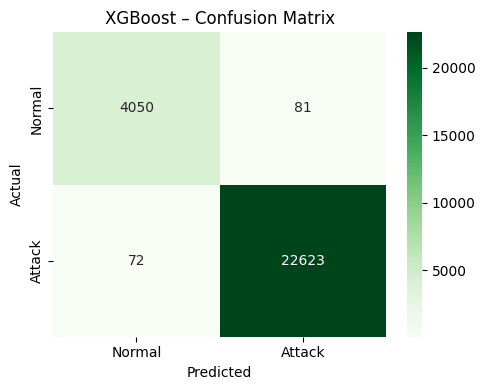

In [ ]:
# ===== -- Step 8: Train & Evaluate XGBoost -- =====

# Initialize XGBoost classifier (CPU only — works fine at this scale)
xgb = XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train on scaled training set
xgb.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred_xgb = xgb.predict(X_val_scaled)

# Evaluate performance
print("🔍 XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
print("\n📊 Classification Report (XGBoost):")
print(classification_report(y_val, y_val_pred_xgb, digits=4))

# Plot confusion matrix
cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal','Attack'], yticklabels=['Normal','Attack'])
plt.title("XGBoost – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


d:\Business\Writing\Writing\Joan\Edge-IIoT Project\venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8001 - loss: 0.4204 - val_accuracy: 0.9034 - val_loss: 0.2346
Epoch 2/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9064 - loss: 0.2198 - val_accuracy: 0.9081 - val_loss: 0.2082
Epoch 3/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9079 - loss: 0.2021 - val_accuracy: 0.9038 - val_loss: 0.2003
Epoch 4/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9096 - loss: 0.1935 - val_accuracy: 0.9066 - val_loss: 0.1918
Epoch 5/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9129 - loss: 0.1833 - val_accuracy: 0.9087 - val_loss: 0.1851
Epoch 6/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9129 - loss: 0.1772 - val_accuracy: 0.9036 - val_loss: 0.1767
Epoch 7/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9149 - loss: 0.1674 - val_accuracy: 0.9091 - val_loss: 0.1698
Epoch 8/15
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9218 - loss: 0.1605 - val_accuracy: 

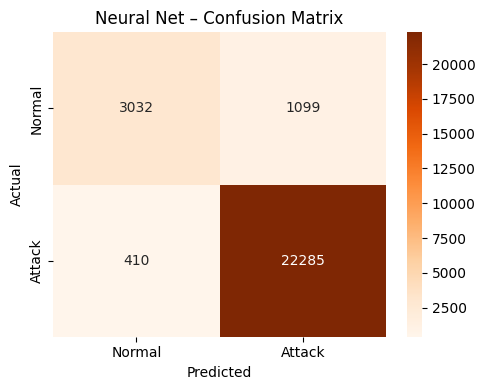

In [ ]:
# ===== -- Step 9: Train & Evaluate Neural Network (Keras) -- =====

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Build the model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=15,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

# Predict on validation set
y_val_pred_nn = nn_model.predict(X_val_scaled)
y_val_pred_nn_labels = (y_val_pred_nn > 0.5).astype(int)

# Evaluate performance
print("\n🔍 Neural Network Validation Accuracy:", accuracy_score(y_val, y_val_pred_nn_labels))
print("\n📊 Classification Report (Neural Net):")
print(classification_report(y_val, y_val_pred_nn_labels, digits=4))

# Plot confusion matrix
cm_nn = confusion_matrix(y_val, y_val_pred_nn_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Oranges', xticklabels=['Normal','Attack'], yticklabels=['Normal','Attack'])
plt.title("Neural Net – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [53]:
# ===== Step B – Poisoning Simulation and Analysis =====
import copy
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Helper function: Flip labels in y_train
def poison_labels(y, poison_rate=0.1, strategy='random'):
    y_poisoned = y.copy()
    n = len(y_poisoned)
    flip_count = int(n * poison_rate)
    
    if strategy == 'random':
        # Randomly pick indices to flip
        indices_to_flip = np.random.choice(n, size=flip_count, replace=False)
        for idx in indices_to_flip:
            y_poisoned[idx] = 1 - y_poisoned[idx]  # flip 0 to 1 and vice versa
    else:
        raise NotImplementedError("Only 'random' strategy implemented so far.")
    
    return y_poisoned

# Store performance metrics
poison_rates = [0.0, 0.05, 0.1, 0.15, 0.2]
f1_scores = []

for rate in poison_rates:
    print(f"\n🚨 Poisoning {int(rate*100)}% of training labels")
    
    # Poisoned copy of training labels
    y_train_poisoned = poison_labels(y_train.values, poison_rate=rate)
    
    # Define fresh neural network model
    poisoned_nn = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    poisoned_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Train the model with poisoned labels
    poisoned_nn.fit(X_train_scaled, y_train_poisoned, validation_data=(X_val_scaled, y_val),
                    epochs=10, batch_size=512, verbose=0)
    
    # Evaluate on clean validation set
    y_val_pred = (poisoned_nn.predict(X_val_scaled) > 0.5).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    
    print(f"F1-Score (Attack class): {f1:.4f}")
    f1_scores.append(f1)



🚨 Poisoning 0% of training labels


d:\Business\Writing\Writing\Joan\Edge-IIoT Project\venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
F1-Score (Attack class): 0.9629

🚨 Poisoning 5% of training labels


d:\Business\Writing\Writing\Joan\Edge-IIoT Project\venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
F1-Score (Attack class): 0.9624

🚨 Poisoning 10% of training labels


d:\Business\Writing\Writing\Joan\Edge-IIoT Project\venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


839/839 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
F1-Score (Attack class): 0.9453

🚨 Poisoning 15% of training labels


d:\Business\Writing\Writing\Joan\Edge-IIoT Project\venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
F1-Score (Attack class): 0.9494

🚨 Poisoning 20% of training labels


d:\Business\Writing\Writing\Joan\Edge-IIoT Project\venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
F1-Score (Attack class): 0.9483


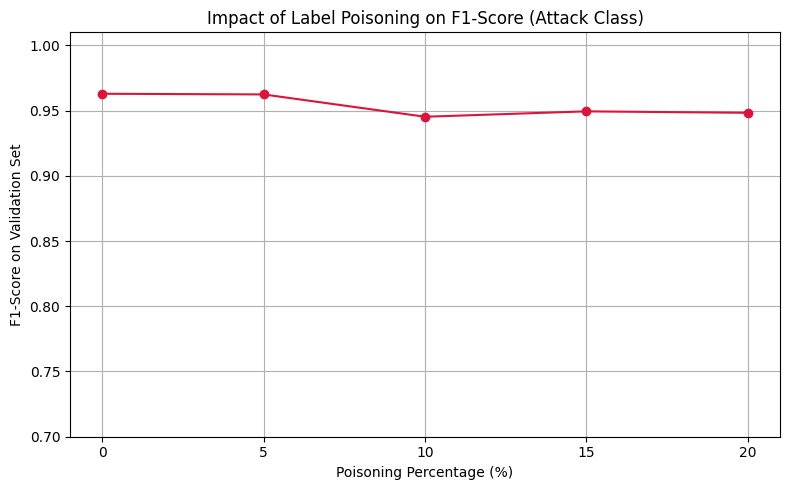

In [54]:
#  ===== -- Plot degradation in F1-score -- =====
plt.figure(figsize=(8,5))
plt.plot([int(r*100) for r in poison_rates], f1_scores, marker='o', color='crimson')
plt.title('Impact of Label Poisoning on F1-Score (Attack Class)')
plt.xlabel('Poisoning Percentage (%)')
plt.ylabel('F1-Score on Validation Set')
plt.grid(True)
plt.xticks([0, 5, 10, 15, 20])
plt.ylim(0.7, 1.01)
plt.tight_layout()
plt.show()
